- Importar bibliotecas necessarias
- Tentar inserir remoção dos registros com mais de 80% de valores ausentes dentro de um transformador de valores numericos (talvez seja necessario criar uma função e aplicá-la no transformador)
- Tentar inserir o iterative imputer tambem dentro de um transformador de valores numericos
- Criar 2 dataframes (Um de treino e outro de teste) gerando um csv para cada dataframe
- Seguir com o modelo em outro notebook, utilizando a função de balanceamento, utilizando pipeline e randomizedSearchCV
- Por fim, atualizar o arquivo do streamlit, se necessario e trabalhar com Docker para hospedar o modelo

*Observação: Na célula responsavel pela separação dos dados em treino e teste, tive que fazer diferente pelo seguinte motivo: Ao realizar o tratamento dos dados apenas com as colunas independentes e ao fim unir a coluna dependente ao DataFrame, alguns registros da coluna dependente (P_HABITABLE) vieram no formato NaN (mesmo que no dataset original não exista registros nulos para esta variável), tendo isto em vista, realizei apenas a separação em treino e teste, sem que a coluna dependente fosse isolada. Portanto, o Iterative Imputer, vai atuar separadamente nos dados de treino e teste, evitando possiveis vazamentos de dados, no entanto, as respectivas colunas P_HABITABLE estarão presentes, mas não devem impactar no desempenho do modelo visto que não haverá atuação do Iterative Imputer nas mesmas.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
dt = pd.read_csv("/content/phl_exoplanet_catalog_2019.csv")

In [ ]:
dt.head(5)

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [ ]:
dt.shape

(4048, 112)

In [ ]:
dt.isnull().sum().sum()

149723

<Axes: >

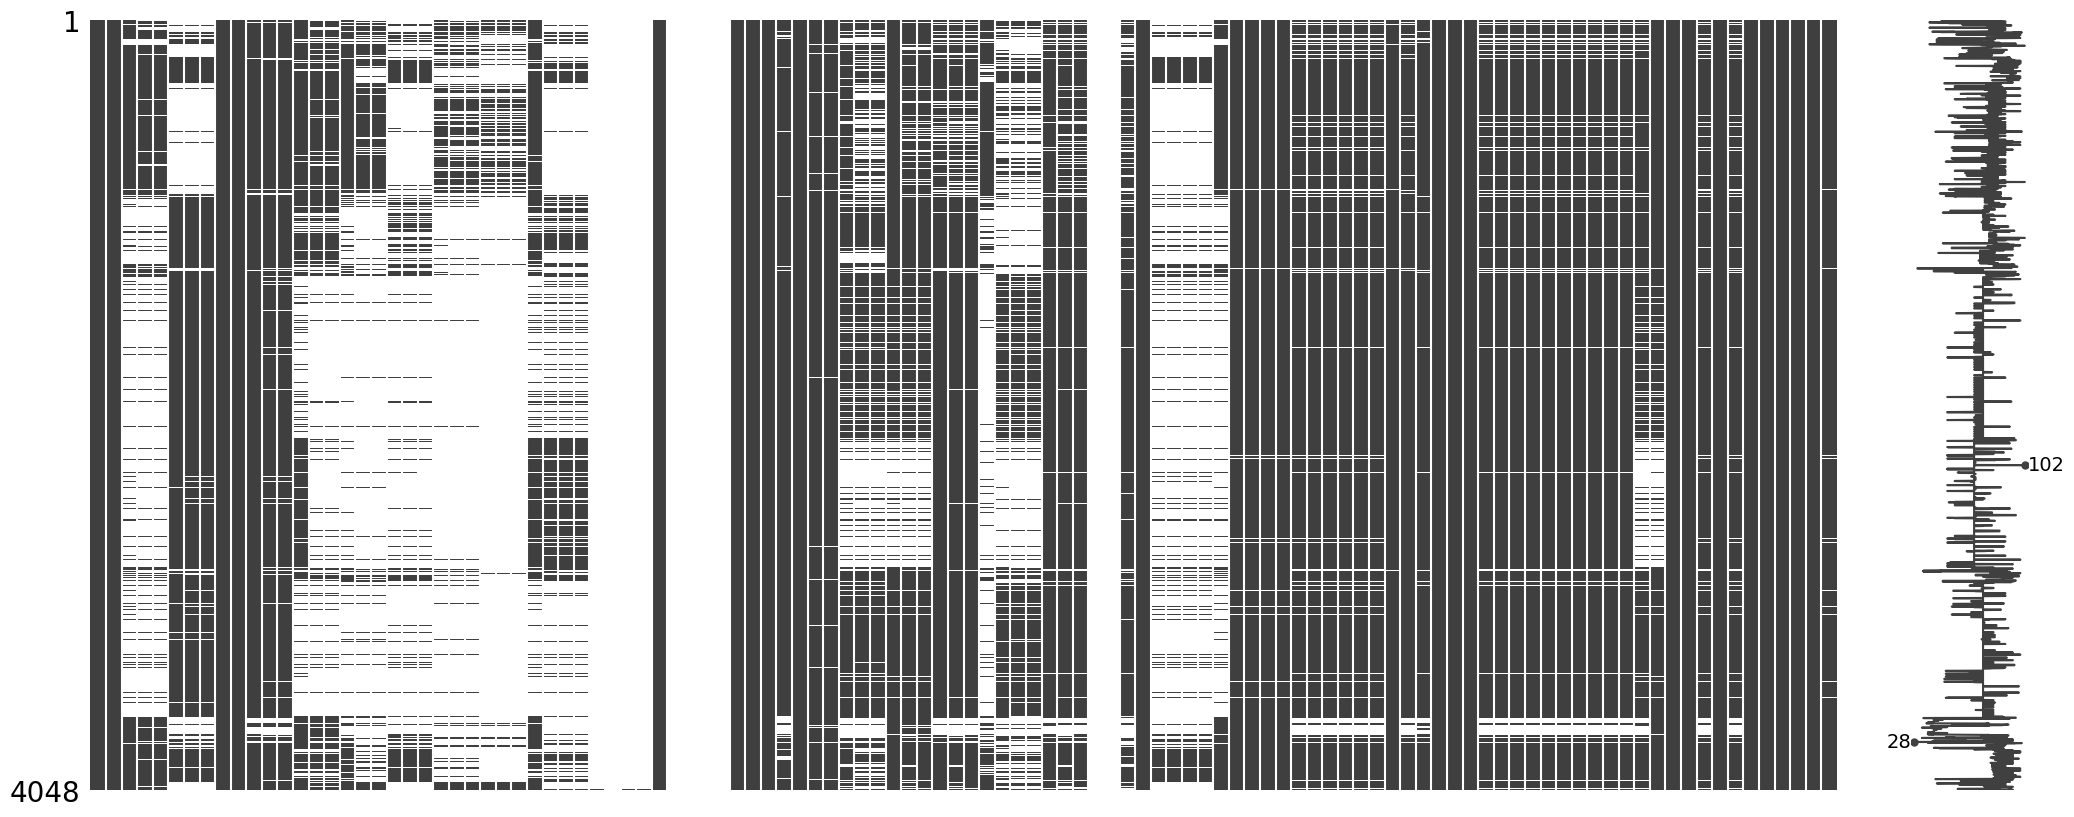

In [ ]:
msno.matrix(dt)

In [ ]:
dt['P_HABITABLE'].value_counts()

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [ ]:
dt['P_STATUS'].value_counts()

3.0    4048
Name: P_STATUS, dtype: int64

In [ ]:
corr_matrix = dt.corr()
corr_df = pd.DataFrame(corr_matrix["P_HABITABLE"].sort_values(ascending=False))
corr_df.head(98)

<ipython-input-14-bec17441c0df>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dt.corr()


,P_HABITABLE
P_HABITABLE,1.000000
P_HABZONE_OPT,0.491481
P_ESI,0.427273
P_HABZONE_CON,0.298875
P_ECCENTRICITY_ERROR_MAX,0.138167
...,...
P_DETECTION_RADIUS,NaN
P_ALT_NAMES,NaN
P_ATMOSPHERE,NaN
S_DISC,NaN


In [ ]:
var = dt.isnull().sum() / dt.shape[0] * 100
print(var.to_string())

P_NAME                            0.000000
P_STATUS                          0.000000
P_MASS                           60.523715
P_MASS_ERROR_MIN                 63.759881
P_MASS_ERROR_MAX                 63.759881
P_RADIUS                         22.455534
P_RADIUS_ERROR_MIN               23.295455
P_RADIUS_ERROR_MAX               23.295455
P_YEAR                            0.000000
P_UPDATED                         0.000000
P_PERIOD                          2.717391
P_PERIOD_ERROR_MIN                5.953557
P_PERIOD_ERROR_MAX                5.953557
P_SEMI_MAJOR_AXIS                41.526680
P_SEMI_MAJOR_AXIS_ERROR_MIN      61.388340
P_SEMI_MAJOR_AXIS_ERROR_MAX      61.363636
P_ECCENTRICITY                   65.909091
P_ECCENTRICITY_ERROR_MIN         76.012846
P_ECCENTRICITY_ERROR_MAX         76.012846
P_INCLINATION                    79.150198
P_INCLINATION_ERROR_MIN          79.940711
P_INCLINATION_ERROR_MAX          79.990119
P_OMEGA                          81.571146
P_OMEGA_ERR

Text(0.5, 1.0, 'Missing Data')

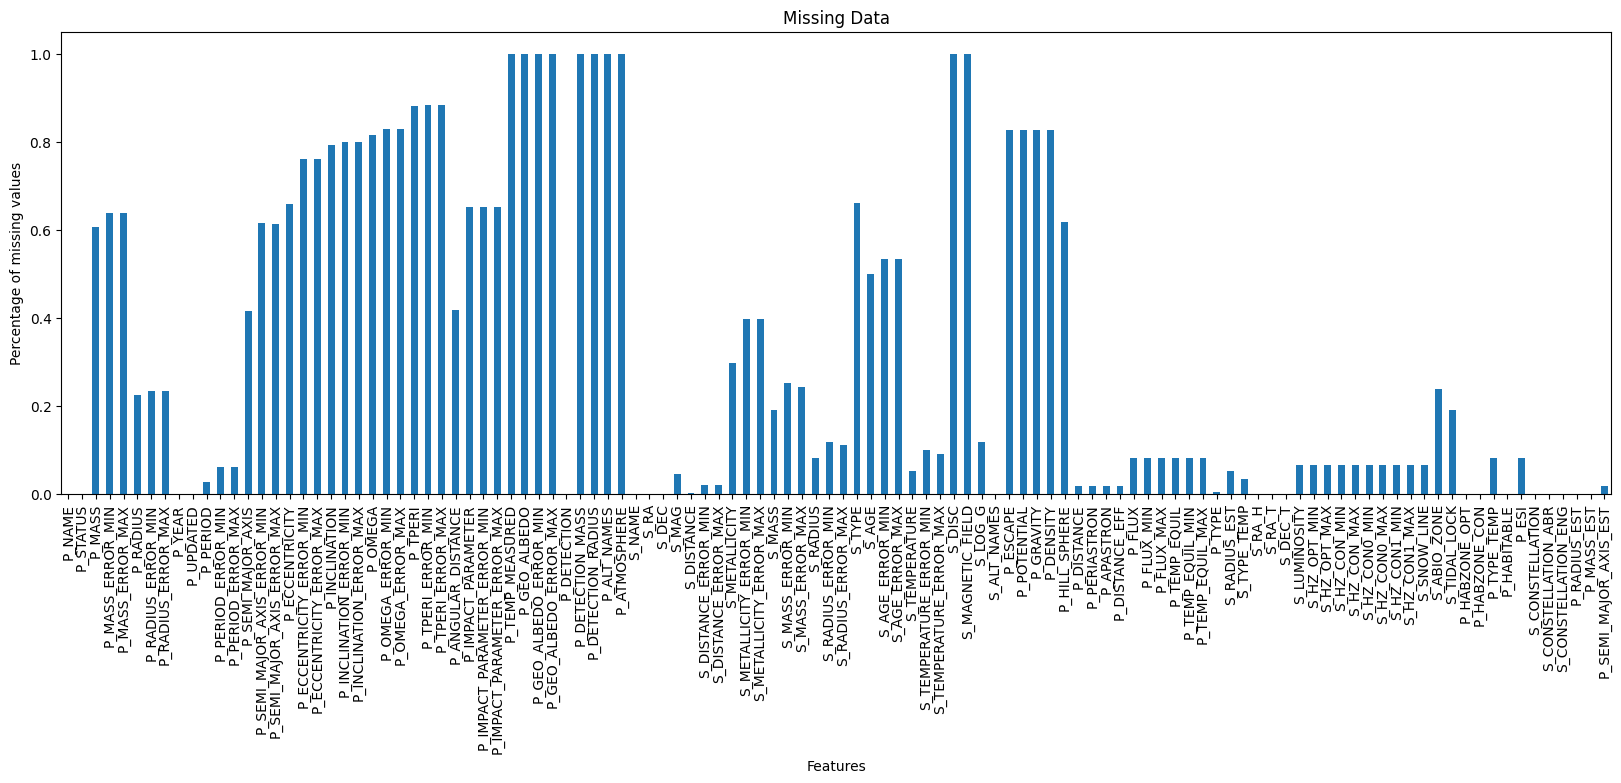

In [ ]:
dt.isnull().mean().plot.bar(figsize=(20,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Features')
plt.title('Missing Data')

In [ ]:
dt.loc[:, dt.isnull().mean() < .20]

,P_NAME,P_STATUS,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_DETECTION,S_NAME,S_RA,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,2007,2014-05-14,326.030000,-0.3200,0.3200,Radial Velocity,11 Com,185.179280,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000
1,11 UMi b,3.0,2009,2018-09-06,516.219970,-3.2000,3.2000,Radial Velocity,11 UMi,229.274540,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000
2,14 And b,3.0,2008,2014-05-14,185.840000,-0.2300,0.2300,Radial Velocity,14 And,352.822570,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.574400,0.83000
3,14 Her b,3.0,2002,2018-09-06,1773.400000,-2.5000,2.5000,Radial Velocity,14 Her,242.601300,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.078500,2.93000
4,16 Cyg B b,3.0,1996,2018-09-06,798.500000,-1.0000,1.0000,Radial Velocity,16 Cyg B,295.466550,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.733850,1.66000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,K2-296 b,3.0,2019,5/23/19,28.165600,0.0028,0.0027,Transit,K2-296,179.705920,...,0,Warm,2,0.755038,Virgo,Vir,Virgin,1.870000,4.155456,0.13456
4044,K2-296 c,3.0,2019,5/23/19,7.906961,0.0000,0.0000,Transit,K2-296,179.705920,...,0,Hot,0,0.363831,Virgo,Vir,Virgin,2.760000,8.047485,0.05769
4045,GJ 1061 b,3.0,2019,9/3/19,3.204000,0.0010,0.0010,Radial Velocity,GJ 1061,53.998749,...,0,Hot,0,0.588562,Horologium,Hor,Pendulum Clock,1.102775,1.380000,0.02100
4046,GJ 1061 c,3.0,2019,9/3/19,6.689000,0.0050,0.0050,Radial Velocity,GJ 1061,53.998749,...,0,Warm,1,0.879042,Horologium,Hor,Pendulum Clock,1.178333,1.750000,0.03500


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

# Separando as colunas numericas em um dataframe especifico
planets_data_new_numeric = dt.select_dtypes(include=np.number)

# Escolhi um estimador não-linear devido ao mix de features categoricas e numericas
#II = IterativeImputer(estimator=RandomForestRegressor(), missing_values=np.NaN, verbose=2, max_iter=3)

In [ ]:
planets_data_new_numeric.columns

Index(['P_STATUS', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX',
       'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_YEAR',
       'P_PERIOD', 'P_PERIOD_ERROR_MIN', 'P_PERIOD_ERROR_MAX',
       'P_SEMI_MAJOR_AXIS', 'P_SEMI_MAJOR_AXIS_ERROR_MIN',
       'P_SEMI_MAJOR_AXIS_ERROR_MAX', 'P_ECCENTRICITY',
       'P_ECCENTRICITY_ERROR_MIN', 'P_ECCENTRICITY_ERROR_MAX', 'P_INCLINATION',
       'P_INCLINATION_ERROR_MIN', 'P_INCLINATION_ERROR_MAX', 'P_OMEGA',
       'P_OMEGA_ERROR_MIN', 'P_OMEGA_ERROR_MAX', 'P_TPERI',
       'P_TPERI_ERROR_MIN', 'P_TPERI_ERROR_MAX', 'P_ANGULAR_DISTANCE',
       'P_IMPACT_PARAMETER', 'P_IMPACT_PARAMETER_ERROR_MIN',
       'P_IMPACT_PARAMETER_ERROR_MAX', 'P_TEMP_MEASURED', 'P_GEO_ALBEDO',
       'P_GEO_ALBEDO_ERROR_MIN', 'P_GEO_ALBEDO_ERROR_MAX', 'P_DETECTION_MASS',
       'P_DETECTION_RADIUS', 'P_ALT_NAMES', 'P_ATMOSPHERE', 'S_RA', 'S_DEC',
       'S_MAG', 'S_DISTANCE', 'S_DISTANCE_ERROR_MIN', 'S_DISTANCE_ERROR_MAX',
       'S_METALLICITY', 'S_M

In [ ]:
# Splitando os dados apenas em 2 conjuntos (treino e teste)
Train, Test = train_test_split(planets_data_new_numeric, test_size=0.3, random_state=42)

In [ ]:
# Function to delete the columns with more than 80% of missing values(nan)
def remove_nan(data):
  thresh = len(data) * .80
  dt_new = data.dropna(thresh = thresh, axis = 1)
  return dt_new

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('remove_null', FunctionTransformer(remove_nan)),
    ('iterative_imputer', IterativeImputer(estimator=RandomForestRegressor(), missing_values=np.NaN, verbose=2, max_iter=3))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, Train.columns)
    ]
)

In [ ]:
Train_treated = preprocessor.fit_transform(Train)

[IterativeImputer] Completing matrix with shape (2833, 49)
[IterativeImputer] Ending imputation round 1/3, elapsed time 429.71
[IterativeImputer] Change: 8325296.417095802, scaled tolerance: 7300.0 
[IterativeImputer] Ending imputation round 2/3, elapsed time 865.87
[IterativeImputer] Change: 968191.6059999997, scaled tolerance: 7300.0 
[IterativeImputer] Ending imputation round 3/3, elapsed time 1301.87
[IterativeImputer] Change: 1025717.3216349987, scaled tolerance: 7300.0 


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
Test_treated = preprocessor.transform(Test)

[IterativeImputer] Completing matrix with shape (1215, 49)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.19
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.39
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.60


In [ ]:
cols_num = ['P_STATUS', 'P_YEAR', 'P_PERIOD', 'P_PERIOD_ERROR_MIN',
       'P_PERIOD_ERROR_MAX', 'S_RA', 'S_DEC', 'S_MAG', 'S_DISTANCE',
       'S_DISTANCE_ERROR_MIN', 'S_DISTANCE_ERROR_MAX', 'S_MASS', 'S_RADIUS',
       'S_RADIUS_ERROR_MIN', 'S_RADIUS_ERROR_MAX', 'S_TEMPERATURE',
       'S_TEMPERATURE_ERROR_MIN', 'S_TEMPERATURE_ERROR_MAX', 'S_LOG_G',
       'P_DISTANCE', 'P_PERIASTRON', 'P_APASTRON', 'P_DISTANCE_EFF', 'P_FLUX',
       'P_FLUX_MIN', 'P_FLUX_MAX', 'P_TEMP_EQUIL', 'P_TEMP_EQUIL_MIN',
       'P_TEMP_EQUIL_MAX', 'S_RADIUS_EST', 'S_RA_H', 'S_LUMINOSITY',
       'S_HZ_OPT_MIN', 'S_HZ_OPT_MAX', 'S_HZ_CON_MIN', 'S_HZ_CON_MAX',
       'S_HZ_CON0_MIN', 'S_HZ_CON0_MAX', 'S_HZ_CON1_MIN', 'S_HZ_CON1_MAX',
       'S_SNOW_LINE', 'S_TIDAL_LOCK', 'P_HABZONE_OPT', 'P_HABZONE_CON','P_HABITABLE',
       'P_ESI', 'P_RADIUS_EST', 'P_MASS_EST', 'P_SEMI_MAJOR_AXIS_EST']

In [ ]:
Train_treated_df = pd.DataFrame(Train_treated, columns=cols_num)
Test_treated_df = pd.DataFrame(Test_treated, columns=cols_num)

In [ ]:
Train_treated_df

,P_STATUS,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,...,S_HZ_CON1_MAX,S_SNOW_LINE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,3.0,2013.0,3016.401961,-714.638200,1325.306400,268.325710,-30.471167,15.67261,4970.00,-290.00,...,2.264668,3.558775,0.350888,0.0,0.0,0.0,0.068949,13.171536,867.670450,3.450000
1,3.0,2016.0,5.215357,-0.000006,0.000006,0.325750,-8.926325,9.98000,164.00,-18.00,...,4.174462,6.999210,0.497068,0.0,0.0,0.0,0.059447,15.469800,479.920280,0.066100
2,3.0,2010.0,3.532690,-0.000010,0.000010,52.818043,-23.819702,12.00000,320.50,-5.60,...,2.197804,3.607715,0.523362,0.0,0.0,0.0,0.066757,13.788300,212.944760,0.051487
3,3.0,2011.0,21.087210,-0.000037,0.000037,296.960260,46.034298,14.46000,1090.44,-19.45,...,2.702027,4.562297,0.440681,0.0,0.0,0.0,0.074577,13.900400,6388.342900,0.164000
4,3.0,2010.0,4.234520,-0.000015,0.000015,213.156380,4.059997,11.74400,142.41,-1.14,...,1.197789,1.813776,0.479097,0.0,0.0,0.0,0.122271,7.062300,22.247960,0.053184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,3.0,2018.0,12.409000,-0.002840,0.003370,183.366670,-8.995114,11.82700,528.30,-14.70,...,3.142431,5.367460,0.506068,0.0,0.0,0.0,0.222211,2.791290,8.202994,0.115100
2829,3.0,2017.0,3.474108,-0.000002,0.000002,294.661410,31.219225,7.58000,139.70,-6.60,...,5.379523,9.586623,0.396662,0.0,0.0,0.0,0.047738,19.516610,1074.894300,0.054200
2830,3.0,2009.0,192.900000,-0.900000,0.900000,23.334101,29.265148,8.36900,50.42,-0.35,...,1.681657,2.712159,0.461336,0.0,0.0,0.0,0.326958,13.408631,578.446970,0.654000
2831,3.0,2016.0,40.068673,-0.000101,0.000101,294.956860,43.014328,14.68300,1072.00,-159.64,...,2.012841,3.309631,0.449440,0.0,0.0,0.0,0.219891,3.945920,14.764686,0.235788


In [ ]:
Test_treated_df

,P_STATUS,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,...,S_HZ_CON1_MAX,S_SNOW_LINE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,3.0,2018.0,4.400028,-0.000178,0.000169,131.266600,13.549833,13.782,283.53,-2.33,...,0.994851,1.480145,0.437009,0.0,0.0,0.0,0.221815,2.948230,9.001313,0.049700
1,3.0,2015.0,30.598700,-0.008400,0.008300,67.148820,-25.169301,11.962,20.20,-0.02,...,0.290035,0.388352,0.345489,1.0,0.0,0.0,0.521227,5.193393,23.538342,0.143390
2,3.0,2014.0,3.408830,-0.000006,0.000006,353.616150,-1.580064,12.030,410.00,-70.00,...,2.004762,3.331845,0.470890,0.0,0.0,0.0,0.067390,13.597730,288.270000,0.044690
3,3.0,2016.0,70.697906,-0.000309,0.000309,295.521210,49.738632,13.046,413.00,-13.30,...,1.545693,2.510535,0.378030,0.0,0.0,0.0,0.418519,1.759970,3.748910,0.331160
4,3.0,2016.0,6.079729,-0.000015,0.000015,284.919430,41.617195,13.532,426.00,-41.61,...,1.399631,2.177100,0.516883,0.0,0.0,0.0,0.271338,1.827230,3.995385,0.062459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,3.0,2018.0,0.669558,-0.000032,0.000032,21.105953,1.704954,13.075,274.39,-4.15,...,1.178079,1.806464,0.442091,0.0,0.0,0.0,0.284625,1.378830,2.477127,0.014350
1211,3.0,2014.0,38.140000,-0.015000,0.015000,264.107910,68.339142,9.150,4.55,0.00,...,0.291736,0.387677,0.353526,1.0,1.0,0.0,0.530898,4.587726,19.069680,0.170000
1212,3.0,2016.0,1.311556,-0.000006,0.000006,288.886640,44.839550,15.371,1161.00,-106.84,...,1.582441,2.526490,0.464808,0.0,0.0,0.0,0.288884,1.266730,2.144985,0.023287
1213,3.0,2014.0,11.131786,-0.000131,0.000131,293.890210,42.528008,13.749,793.01,-9.20,...,2.375399,3.929155,0.470954,0.0,0.0,0.0,0.297012,1.199470,1.865146,0.103000


In [ ]:
var = Train_treated_df.isnull().sum()
print(var.to_string())

P_STATUS                   0
P_YEAR                     0
P_PERIOD                   0
P_PERIOD_ERROR_MIN         0
P_PERIOD_ERROR_MAX         0
S_RA                       0
S_DEC                      0
S_MAG                      0
S_DISTANCE                 0
S_DISTANCE_ERROR_MIN       0
S_DISTANCE_ERROR_MAX       0
S_MASS                     0
S_RADIUS                   0
S_RADIUS_ERROR_MIN         0
S_RADIUS_ERROR_MAX         0
S_TEMPERATURE              0
S_TEMPERATURE_ERROR_MIN    0
S_TEMPERATURE_ERROR_MAX    0
S_LOG_G                    0
P_DISTANCE                 0
P_PERIASTRON               0
P_APASTRON                 0
P_DISTANCE_EFF             0
P_FLUX                     0
P_FLUX_MIN                 0
P_FLUX_MAX                 0
P_TEMP_EQUIL               0
P_TEMP_EQUIL_MIN           0
P_TEMP_EQUIL_MAX           0
S_RADIUS_EST               0
S_RA_H                     0
S_LUMINOSITY               0
S_HZ_OPT_MIN               0
S_HZ_OPT_MAX               0
S_HZ_CON_MIN  

In [ ]:
var = Test_treated_df.isnull().sum()
print(var.to_string())

P_STATUS                   0
P_YEAR                     0
P_PERIOD                   0
P_PERIOD_ERROR_MIN         0
P_PERIOD_ERROR_MAX         0
S_RA                       0
S_DEC                      0
S_MAG                      0
S_DISTANCE                 0
S_DISTANCE_ERROR_MIN       0
S_DISTANCE_ERROR_MAX       0
S_MASS                     0
S_RADIUS                   0
S_RADIUS_ERROR_MIN         0
S_RADIUS_ERROR_MAX         0
S_TEMPERATURE              0
S_TEMPERATURE_ERROR_MIN    0
S_TEMPERATURE_ERROR_MAX    0
S_LOG_G                    0
P_DISTANCE                 0
P_PERIASTRON               0
P_APASTRON                 0
P_DISTANCE_EFF             0
P_FLUX                     0
P_FLUX_MIN                 0
P_FLUX_MAX                 0
P_TEMP_EQUIL               0
P_TEMP_EQUIL_MIN           0
P_TEMP_EQUIL_MAX           0
S_RADIUS_EST               0
S_RA_H                     0
S_LUMINOSITY               0
S_HZ_OPT_MIN               0
S_HZ_OPT_MAX               0
S_HZ_CON_MIN  

In [ ]:
Train_treated_df.to_csv('Treated_numeric_columns_phl(20%)_pipe_Train.csv')
Test_treated_df.to_csv('Treated_numeric_columns_phl(20%)_pipe_Test.csv')

In [ ]:
treated = pd.read_csv("/content/Treated_numeric_columns_phl(20%)_pipe_Train.csv")

In [ ]:
var = treated.head(15)
print(var.to_string())

    Unnamed: 0  P_STATUS  P_YEAR      P_PERIOD  P_PERIOD_ERROR_MIN  P_PERIOD_ERROR_MAX        S_RA      S_DEC     S_MAG  S_DISTANCE  S_DISTANCE_ERROR_MIN  S_DISTANCE_ERROR_MAX  S_MASS  S_RADIUS  S_RADIUS_ERROR_MIN  S_RADIUS_ERROR_MAX  S_TEMPERATURE  S_TEMPERATURE_ERROR_MIN  S_TEMPERATURE_ERROR_MAX  S_LOG_G  P_DISTANCE  P_PERIASTRON  P_APASTRON  P_DISTANCE_EFF        P_FLUX    P_FLUX_MIN    P_FLUX_MAX  P_TEMP_EQUIL  P_TEMP_EQUIL_MIN  P_TEMP_EQUIL_MAX  S_RADIUS_EST     S_RA_H  S_LUMINOSITY  S_HZ_OPT_MIN  S_HZ_OPT_MAX  S_HZ_CON_MIN  S_HZ_CON_MAX  S_HZ_CON0_MIN  S_HZ_CON0_MAX  S_HZ_CON1_MIN  S_HZ_CON1_MAX  S_SNOW_LINE  S_TIDAL_LOCK  P_HABZONE_OPT  P_HABZONE_CON  P_HABITABLE     P_ESI  P_RADIUS_EST  P_MASS_EST  P_SEMI_MAJOR_AXIS_EST
0            0       3.0  2007.0  3.260300e+02           -0.320000             0.32000  185.179280  17.792868   4.74000       93.37               -1.9200                1.9200    2.70   19.0000             -2.0000              2.0000        4742.00              

In [ ]:
var = treated.dtypes
print(var.to_string())

Unnamed: 0                   int64
P_STATUS                   float64
P_YEAR                     float64
P_PERIOD                   float64
P_PERIOD_ERROR_MIN         float64
P_PERIOD_ERROR_MAX         float64
S_RA                       float64
S_DEC                      float64
S_MAG                      float64
S_DISTANCE                 float64
S_DISTANCE_ERROR_MIN       float64
S_DISTANCE_ERROR_MAX       float64
S_MASS                     float64
S_RADIUS                   float64
S_RADIUS_ERROR_MIN         float64
S_RADIUS_ERROR_MAX         float64
S_TEMPERATURE              float64
S_TEMPERATURE_ERROR_MIN    float64
S_TEMPERATURE_ERROR_MAX    float64
S_LOG_G                    float64
P_DISTANCE                 float64
P_PERIASTRON               float64
P_APASTRON                 float64
P_DISTANCE_EFF             float64
P_FLUX                     float64
P_FLUX_MIN                 float64
P_FLUX_MAX                 float64
P_TEMP_EQUIL               float64
P_TEMP_EQUIL_MIN    